## Регрессия для IC50

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap

In [ ]:
df_aggregated = pd.read_csv('aggregated_data1.csv')

In [ ]:
def prepare_data():
    # Удаляем ненужные столбцы
    cols_to_drop = ["IC50, mM", "CC50, mM", "SI", "log_CC50", "log_SI"]
    data = df_aggregated.drop(columns=cols_to_drop, errors='ignore')

    # Проверяем наличие целевой переменной
    if 'log_IC50' not in data.columns:
        raise ValueError("log_IC50 не найден в данных")

    return data

data = prepare_data()
print("Данные подготовлены. Столбцы:", data.columns.tolist())

Данные подготовлены. Столбцы: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11',

In [ ]:
# Разделяем данные на на обучающую и тестовую выборки

def split_data(data):
    X = data.drop(columns=['log_IC50'])
    y = data['log_IC50']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data)
print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")


Train: (800, 223), Test: (201, 223)


In [ ]:
# Масштабирование признаков

def scale_features(X_train, X_test):
    numeric_cols = X_train.select_dtypes(include=np.number).columns
    scaler = RobustScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train_scaled, X_test_scaled, scaler, numeric_cols

X_train_scaled, X_test_scaled, scaler, numeric_cols = scale_features(X_train, X_test)
print("\nМасштабирование признаков выполнено.")


Масштабирование признаков выполнено.


In [ ]:
# Обучение нескольких моделей

# LinearRegression
def train_linear_regression(X_train, y_train):
    print("\nОбучение Linear Regression")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return lr

# Random Forest
def train_random_forest(X_train, y_train):
    print("\nОбучение Random Forest")
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }
    rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error')
    rf_grid.fit(X_train, y_train)
    return rf_grid.best_estimator_

# XGBoost
def train_xgboost(X_train, y_train):
    print("\nОбучение XGBoost")
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    xgb_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }
    xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error')
    xgb_grid.fit(X_train, y_train)
    return xgb_grid.best_estimator_

# LightGBM
def train_lightgbm(X_train, y_train):
    print("\nОбучение LightGBM")
    lgbm = LGBMRegressor(random_state=42, n_jobs=-1)
    lgbm_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, -1],
        'learning_rate': [0.01, 0.1]
    }
    lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=5, scoring='neg_mean_squared_error')
    lgbm_grid.fit(X_train, y_train)
    return lgbm_grid.best_estimator_

# CatBoost
def train_catboost(X_train, y_train):
    print("\nОбучение CatBoost")
    cb = CatBoostRegressor(random_state=42, verbose=0)
    cb_params = {
        'iterations': [100, 200],
        'depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }
    cb_grid = GridSearchCV(cb, cb_params, cv=5, scoring='neg_mean_squared_error')
    cb_grid.fit(X_train, y_train)
    return cb_grid.best_estimator_

# SVR
def train_svr(X_train, y_train):
    print("\nОбучение SVR")
    svr = SVR(kernel='rbf')
    svr_params = {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1]
    }
    svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error')
    svr_grid.fit(X_train, y_train)
    return svr_grid.best_estimator_

# Обучаем все модели
models = {
    'Linear Regression': train_linear_regression(X_train_scaled, y_train),
    'Random Forest': train_random_forest(X_train_scaled, y_train),
    'XGBoost': train_xgboost(X_train_scaled, y_train),
    'LightGBM': train_lightgbm(X_train_scaled, y_train),
    'CatBoost': train_catboost(X_train_scaled, y_train),
    'SVR': train_svr(X_train_scaled, y_train)
}

print("\nВсе модели успешно обучены!")

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

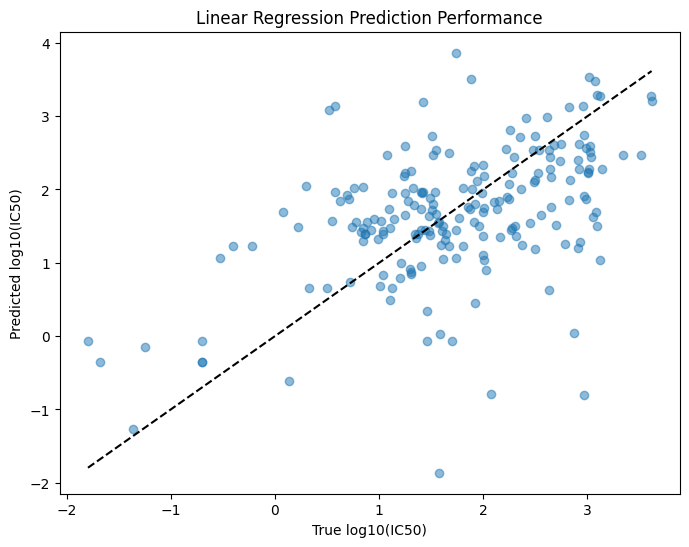

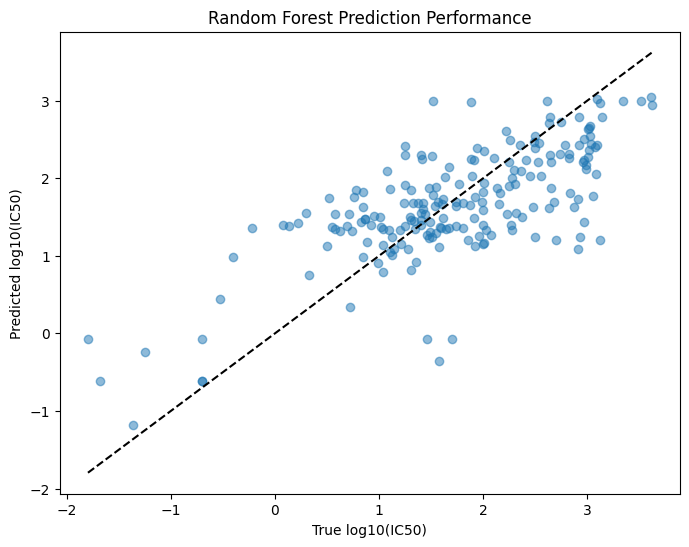

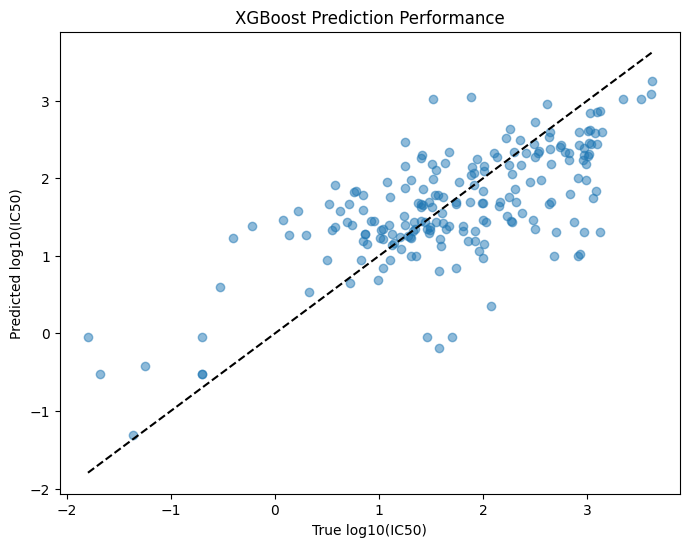

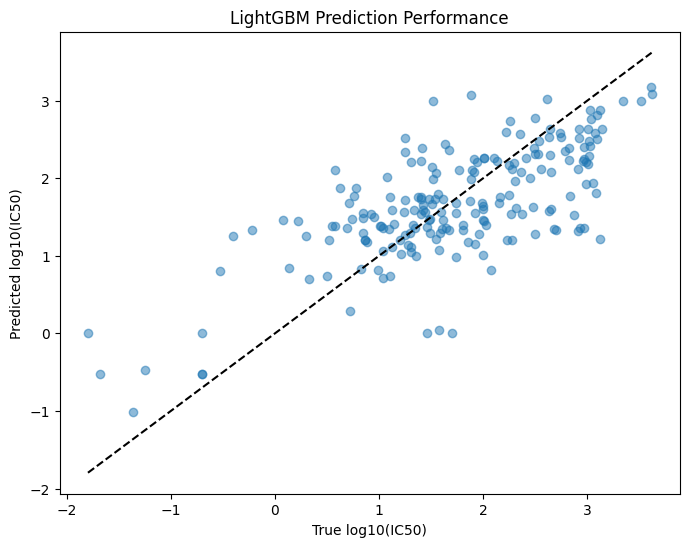

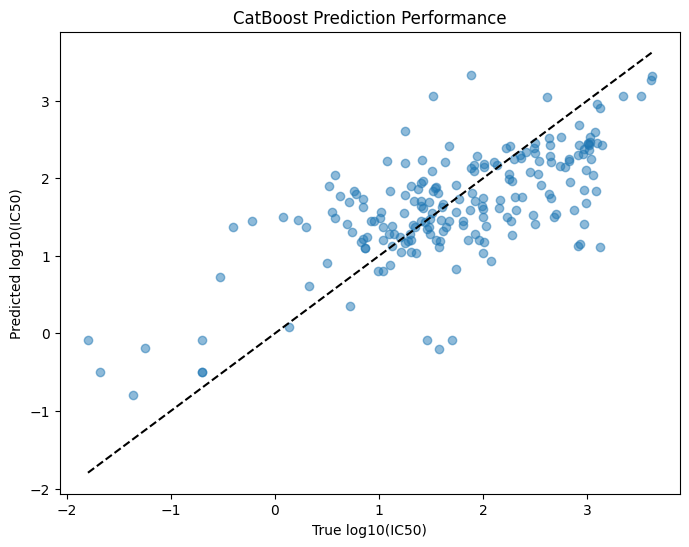

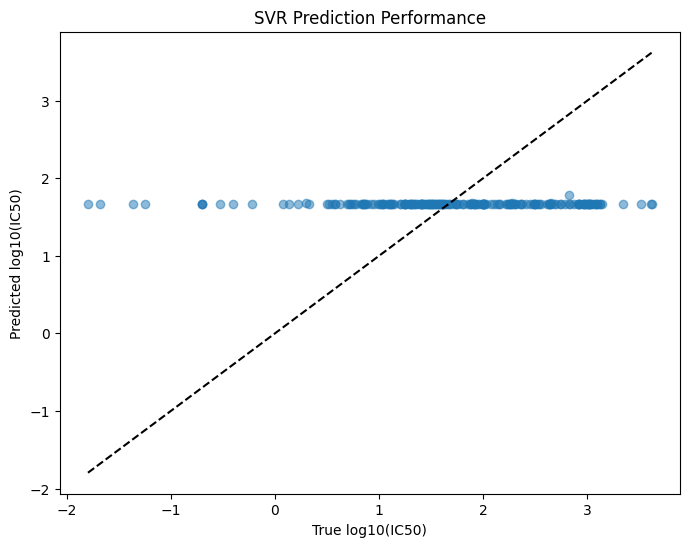


Результаты оценки моделей:
|     RMSE |      MAE |          R2 | Model             |
|---------:|---------:|------------:|:------------------|
| 0.697227 | 0.545104 |  0.512048   | Random Forest     |
| 0.705128 | 0.556409 |  0.500927   | LightGBM          |
| 0.719521 | 0.55959  |  0.480346   | CatBoost          |
| 0.723273 | 0.558429 |  0.474912   | XGBoost           |
| 0.955672 | 0.714513 |  0.0832615  | Linear Regression |
| 0.99966  | 0.777744 | -0.00307435 | SVR               |


In [ ]:
# Проведем оценку моделей и визуализируем результаты

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

def evaluate_all_models(models, X_test, y_test):
    results = []

    for name, model in models.items():
        metrics = evaluate_model(model, X_test, y_test)
        metrics['Model'] = name
        results.append(metrics)

        # Визуализация предсказаний
        y_pred = model.predict(X_test)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('True log10(IC50)')
        plt.ylabel('Predicted log10(IC50)')
        plt.title(f'{name} Prediction Performance')
        plt.show()

    return pd.DataFrame(results)

results_df = evaluate_all_models(models, X_test_scaled, y_test)
print("\nРезультаты оценки моделей:")
print(results_df.sort_values('R2', ascending=False).to_markdown(index=False))

Лучший результат показала модель Random Forest. Показывает наименьшую ошибку (RMSE, MAE) и наилучшую объясняющую способность (R²). Устойчива к переобучению и хорошая обобщающая способность.

RMSE = 0.697, MAE = 0.545, R² = 0.512

LightGBM – второй по эффективности, чуть хуже Random Forest, но работает быстрее и хорошо масштабируется на больших данных.

RMSE = 0.705, MAE = 0.556, R² = 0.501
